# Plot data in an automated way using cartopy

* Purpose of script: Create images to show the BWS variance over the year
* Author: Rutger Hofste
* Kernel used: python35 Cartopy
* Date created: 20171110

In [1]:
%matplotlib inline

In [2]:
import time, datetime, sys
dateString = time.strftime("Y%YM%mD%d")
timeString = time.strftime("UTC %H:%M")
start = datetime.datetime.now()
print(dateString,timeString)
print(sys.version)
%matplotlib inline

Y2017M11D10 UTC 17:50
3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 13:26:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


## Settings

In [3]:
SCRIPT_NAME = "Y2017M11D10_RH_Vizualize_Cartopy_BWS_V01"

INPUT_VERSION_TABLE = 6
INPUT_VERSION_SHAPE = 1

S3_INPUT_PATH_TABLE = "s3://wri-projects/Aqueduct30/processData/Y2017M10D04_RH_Threshold_WaterStress_V02/output/"
S3_INPUT_PATH_SHAPE = "s3://wri-projects/Aqueduct30/processData/Y2017M08D29_RH_Merge_FAONames_Upstream_V01/output/"
S3_OUTPUT_PATH = "s3://wri-projects/Aqueduct30/processData/%s/output/" %(SCRIPT_NAME)

EC2_INPUT_PATH = "/volumes/data/%s/input" %(SCRIPT_NAME)
EC2_OUTPUT_PATH = "/volumes/data/%s/output" %(SCRIPT_NAME)

INPUT_FILE_NAME_TABLE = "Y2017M10D04_RH_Threshold_WaterStress_V%0.2d" %(INPUT_VERSION_TABLE)
INPUT_FILE_NAME_SHAPE = "hybas_lev06_v1c_merged_fiona_upstream_downstream_FAO_V%0.2d" %(INPUT_VERSION_SHAPE)

# Extent
x0 = -1
x1 = 5
y0 = 35
y1 = 45



In [ ]:
!rm -r {EC2_INPUT_PATH} 
!rm -r {EC2_OUTPUT_PATH} 

In [ ]:
!mkdir -p {EC2_INPUT_PATH} 
!mkdir -p {EC2_OUTPUT_PATH} 

In [ ]:
!aws s3 cp {S3_INPUT_PATH_TABLE} {EC2_INPUT_PATH} --recursive

In [ ]:
!aws s3 cp {S3_INPUT_PATH_SHAPE} {EC2_INPUT_PATH} --recursive

In [40]:
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import Point, Polygon

In [51]:
def createExtent(x0,x1,y0,y1):
    coords = [(x0,y0), (x1,y0), (x1, y1), (x0, y1)]
    extent = Polygon(coords)
    extentGdf = gpd.GeoDataFrame()
    extentGdf.loc[0, 'geometry'] = extent
    return extentGdf

def removeInvalid(gdf):
    gdf2 = gdf.copy()
    gdf2["isValid"] = gdf.geometry.is_valid
    gdfOut = gdf[gdf2['isValid']==True]
    return gdfOut


In [42]:
df = pd.read_pickle(os.path.join(EC2_INPUT_PATH,INPUT_FILE_NAME_TABLE+".pkl"))

In [43]:
gdf = gpd.read_file(os.path.join(EC2_INPUT_PATH,INPUT_FILE_NAME_SHAPE+".shp"))

In [44]:
gdf = gdf.set_index("PFAF_ID", drop=False)

In [45]:
gdf2 = gdf.copy()

In [46]:
gdf3 = gdf2.loc[gdf2['PFAF_ID'].between(210000,220000)]

In [47]:
gdf4 = gdf2.loc[gdf2['PFAF_ID'].between(230000,240000)]

In [48]:
gdfRegion = gdf3.append(gdf4)

In [52]:
gdfRegionValid = removeInvalid(gdfRegion)

In [49]:
extentGdf = createExtent(x0,x1,y0,y1)

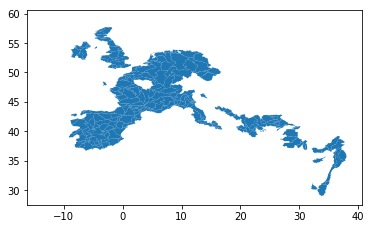

In [53]:
gdfRegionValid.plot()

In [34]:
gdf4["isValid"] = gdf4.geometry.is_valid

/opt/anaconda3/envs/python35cartopy/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
gdf4 = gdf4[gdf4['isValid']==True]

In [ ]:
gdf3

In [36]:
res_union = gpd.overlay(gdf4, extentGdf, how='intersection')

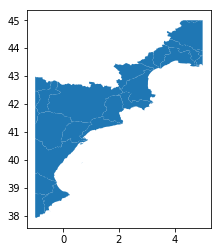

In [37]:
res_union.plot()